# Mask2Former ingranaggio con poligoni

## Data cleaning

In [7]:
import torch
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor

processor = Mask2FormerImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-semantic")

print(processor.num_labels)

150


c:\Users\SimoneG\Desktop\notebooks_tesi\pytorch-env\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


In [ ]:
# Script per convertire le immagini da BMP a PNG

# import os
# import shutil

# images_bmp_dir = r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\images"
# images_png_dir = r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\images_png"

# for filename in os.listdir(images_bmp_dir):
#     if filename.endswith(".bmp"):
#         bmp_path = os.path.join(images_bmp_dir, filename)
#         png_path = os.path.join(images_png_dir, filename.replace(".bmp", ".png"))
#         shutil.copy(bmp_path, png_path)

## Dataset split

In [9]:
import os
import shutil
import random

random.seed(42)  

img_dir = r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\images_PNG"
mask_dir = r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\masks_binary"

output_base = "./dataset_split"
splits = ["train", "val", "test"]
split_ratio = [0.8, 0.1, 0.1]  # modifica se vuoi solo train/val

# Crea le directory
for split in splits:
    os.makedirs(os.path.join(output_base, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_base, split, "masks"), exist_ok=True)

# File comuni tra immagini e maschere
all_files = [f for f in os.listdir(img_dir) if f.endswith(".png")]
random.shuffle(all_files)

n = len(all_files)
train_end = int(n * split_ratio[0])
val_end = train_end + int(n * split_ratio[1])

split_files = {
    "train": all_files[:train_end],
    "val": all_files[train_end:val_end],
    "test": all_files[val_end:]
}

# Copia file nelle cartelle
for split, files in split_files.items():
    for f in files:
        shutil.copy(os.path.join(img_dir, f), os.path.join(output_base, split, "images", f))
        shutil.copy(os.path.join(mask_dir, f), os.path.join(output_base, split, "masks", f))

print("✅ Split completato!")

✅ Split completato!


## Image preprocessing

In [16]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np


# Dataset personalizzato
class DefectSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_size=(512, 512)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_size = image_size

        # Lista dei file immagine
        self.image_files = sorted([
            f for f in os.listdir(images_dir) if f.endswith('.png')
        ])

        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize(image_size, interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx) -> dict:
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_filename)

        # Nome maschera associata
        mask_filename = f"{os.path.splitext(image_filename)[0]}.png"
        mask_path = os.path.join(self.masks_dir, mask_filename)

        # Carica immagine e maschera
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # scala di grigi

        # Resize coerente
        image = self.resize(image)
        mask = self.resize(mask)

        # Maschera binaria → [0, 1]
        mask_array = np.array(mask)
        if mask_array.max() > 1:  # se non è già binaria
            mask_array = (mask_array > 127).astype(np.uint8)
        # mask_array = (mask_array > 127).astype(np.uint8)  # threshold. Ho commentato perchè sono già binarie
        mask_tensor = torch.from_numpy(mask_array).float()  # shape [H, W]

        # Aggiungi dimensione N (numero maschere)
        mask_tensor = mask_tensor.unsqueeze(0)  # [1, H, W]
        class_labels = torch.tensor([0], dtype=torch.long)  # "difetto" = 0. Poi vare id2label = {0: "difetto"}

        # Processa immagine
        inputs = processor(images=image, return_tensors="pt")

        pixel_values = inputs["pixel_values"].squeeze(0)  # [C, H, W]
        pixel_mask = inputs["pixel_mask"].squeeze(0)      # [H, W]

        return {
            "pixel_values": pixel_values,
            "pixel_mask": pixel_mask,
            "mask_labels": mask_tensor,
            "class_labels": class_labels,
            "image_id": image_filename,
        }

## Creazione collate_fn()

In pratica ho:  
{  
    "pixel_values": [C, H, W],  
    "pixel_mask": [H, W],  
    "mask_labels": [N, H, W],  
    "class_labels": [N],  
    "image_id": string  
}  
e voglio arrivare ad avere batches così:  
{  
    "pixel_values": [B, C, H, W],  
    "pixel_mask": [B, H, W],  
    "mask_labels": [B, N, H, W],  
    "class_labels": [B, N],  
    "image_id": list of strings  
}  

Cosa fa stack?  

x = tensor([[-1.4265,  0.4837, -0.2788],  
            [-1.2494,  1.0760, -0.4551]])  

y = tensor([[1., 1., 1.],  
            [1., 1., 1.]])  

stacked = torch.stack((*x*,*y*), dim=0)  

stacked = tensor([[[-1.4265,  0.4837, -0.2788],  
         [-1.2494,  1.0760, -0.4551]],  

        [[ 1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000]]])

In [3]:
def collate_fn(batch):
    batch = [x for x in batch if x is not None] # rimuovi None
    # print(f"Rimossi batch None. Batch size: {len(batch)}")

    # pixel_values: [B, C, H, W]
    pixel_values = torch.stack([item["pixel_values"] for item in batch])

    # pixel_mask: [B, H, W]
    pixel_mask = torch.stack([item["pixel_mask"] for item in batch])

    # mask_labels: [B, N, H, W]
    mask_labels = torch.stack([item["mask_labels"] for item in batch])

    # class_labels: [B, N]
    class_labels = torch.stack([item["class_labels"] for item in batch])

    # image_id: lista di stringhe (non tensori)
    #image_ids = [item["image_id"] for item in batch]

    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "mask_labels": mask_labels,
        "class_labels": class_labels,
        #"image_id": image_ids
    }

## Creazione DataLoader

In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    DefectSegmentationDataset(
        images_dir=r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\dataset_split\train\images",
        masks_dir=r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\dataset_split\train\masks",
        image_size=(512, 512)  # dimensione immagine
    )
    , batch_size=4, shuffle=True, collate_fn=collate_fn
)

# train_loader.dataset[0] 

In [5]:
print(train_loader.dataset[0].keys())  # controlla le chiavi del dizionario
print(train_loader.dataset[0]["pixel_values"].shape)  # forma del tensore immagine
print(train_loader.dataset[0]["pixel_mask"].shape)  # forma del tensore immagine
print(train_loader.dataset[0]["mask_labels"].shape)  # forma del tensore immagine
print(train_loader.dataset[0]["class_labels"].shape)  # forma del tensore immagine


dict_keys(['pixel_values', 'pixel_mask', 'mask_labels', 'class_labels', 'image_id'])
torch.Size([3, 384, 384])
torch.Size([384, 384])
torch.Size([1, 512, 512])
torch.Size([1])


In [6]:
val_loader = DataLoader(
    DefectSegmentationDataset(
        images_dir=r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\dataset_split\val\images",
        masks_dir=r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\dataset_split\val\masks",
        image_size=(512, 512)  # dimensione immagine
    )
    , batch_size=4, shuffle=False, collate_fn=collate_fn
)

## Training

In [8]:
! wandb login --relogin b09e99da50efd362ec0f9e98af5df31bb452be8d

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\SimoneG\_netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [13]:
# aggiungere learning rate, early stopping, wandb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    "facebook/mask2former-swin-large-ade-semantic",
    #id2label={0: "Defect", 1: "Background"},
    #label2id={"Defect": 0, "Background": 1},
    id2label={0: "Defect"},
    label2id={"Defect": 0},
    num_labels=1,
    ignore_mismatched_sizes=True,
).to(device)

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback


training_args = TrainingArguments(
    output_dir="./results_ingranaggioNew2",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    remove_unused_columns=False,  # importante per segmentation
    report_to="wandb",
    run_name="mask2former-ingranaggioNew2",
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_loader.dataset,
    eval_dataset=val_loader.dataset,
    data_collator=collate_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

Using device: cuda


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([2]) in the model instantiated
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,4.356497
2,5.705700,3.808846
3,5.705700,3.688416
4,3.399400,3.367929
5,3.399400,3.755912
6,2.851600,3.459106
7,2.297900,4.053438
8,2.297900,4.489532
9,1.958800,4.275273
10,1.958800,5.325094


KeyboardInterrupt: 

In [ ]:
trainer.save_model("./model_mask2former_defect1")

## Inferenza

In [ ]:
from transformers import Mask2FormerForUniversalSegmentation
import torch

checkpoint_path = r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\results_ingranaggioNew1\checkpoint-1160"

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint_path,
    ignore_mismatched_sizes=True,
)
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

odict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])


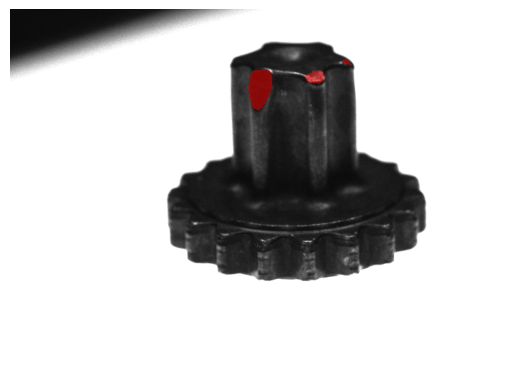

In [ ]:
from transformers import AutoImageProcessor

# Carica il processor associato al modello
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-semantic")

from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
import torch.nn.functional as F

image = Image.open(r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\dataset_split\test\images\e5e18cb9-Sample_C2_NOK_0170.png").convert("RGB")

# Carica immagine
inputs = processor(images=image, return_tensors="pt").to(model.device)

# Esegui inferenza
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

print(outputs.keys())
# Ottieni logits delle maschere predette
pred_masks = outputs.masks_queries_logits[0]  # [num_queries, H, W]
pred_logits = outputs.class_queries_logits[0]  # [num_queries, num_classes+1]

# Trova le predizioni più sicure (escludi background)
scores = pred_logits.softmax(-1)
labels = scores.argmax(-1)
keep = (labels != model.config.num_labels) & (scores.max(-1).values > 0.9)  # Adjusted threshold

filtered_masks = pred_masks[keep]
filtered_labels = labels[keep]

# Handle case where no masks are detected
if filtered_masks.shape[0] == 0:
    print("No masks detected with the current threshold.")
    # Display original image
    plt.imshow(image)
    plt.title("No masks detected")
    plt.axis('off')
    plt.show()
else:
    image_tensor_for_drawing = transforms.PILToTensor()(image)

    # Resize pred_masks to match image size
    original_size = image.size  # (W, H)
    target_height, target_width = original_size[1], original_size[0]

    # filtered_masks: [N, H_pred, W_pred] -> add batch dim to interpolate
    filtered_masks = F.interpolate(
        filtered_masks.unsqueeze(0),  # [1, N, H_pred, W_pred]
        size=(target_height, target_width),
        mode="bilinear",
        align_corners=False
    ).squeeze(0)  # Back to [N, H, W]


    # Le maschere devono essere binarie per il disegno
    masks_bin = filtered_masks > 0.5  # [N, H, W]
    masks_bin = masks_bin.cpu()

    # Disegna le maschere sull'immagine tensor
    overlay = draw_segmentation_masks(
        image_tensor_for_drawing, # Passa il tensore uint8
        masks=masks_bin,
        alpha=0.5,
        colors="red"
    )

    # Converti il tensore risultante in un'immagine PIL per visualizzazione
    overlay_pil = to_pil_image(overlay)

    # Transpose the tensor to have shape (H, W, C) before displaying
    plt.imshow(overlay.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

odict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])


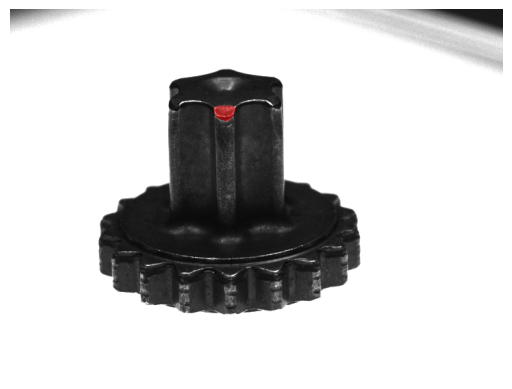

In [52]:

image = Image.open(r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\dataset_split\test\images\b742bbca-Sample_C3_0074.png").convert("RGB")

# Carica immagine
inputs = processor(images=image, return_tensors="pt").to(model.device)

# Esegui inferenza
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

print(outputs.keys())
# Ottieni logits delle maschere predette
pred_masks = outputs.masks_queries_logits[0]  # [num_queries, H, W]
pred_logits = outputs.class_queries_logits[0]  # [num_queries, num_classes+1]

# Trova le predizioni più sicure (escludi background)
scores = pred_logits.softmax(-1)
labels = scores.argmax(-1)
keep = (labels != model.config.num_labels) & (scores.max(-1).values > 0.95)  # Adjusted threshold

filtered_masks = pred_masks[keep]
filtered_labels = labels[keep]

# Handle case where no masks are detected
if filtered_masks.shape[0] == 0:
    print("No masks detected with the current threshold.")
    # Display original image
    plt.imshow(image)
    plt.title("No masks detected")
    plt.axis('off')
    plt.show()
else:
    image_tensor_for_drawing = transforms.PILToTensor()(image)

    # Resize pred_masks to match image size
    original_size = image.size  # (W, H)
    target_height, target_width = original_size[1], original_size[0]

    # filtered_masks: [N, H_pred, W_pred] -> add batch dim to interpolate
    filtered_masks = F.interpolate(
        filtered_masks.unsqueeze(0),  # [1, N, H_pred, W_pred]
        size=(target_height, target_width),
        mode="bilinear",
        align_corners=False
    ).squeeze(0)  # Back to [N, H, W]


    # Le maschere devono essere binarie per il disegno
    masks_bin = filtered_masks > 0.5  # [N, H, W]
    masks_bin = masks_bin.cpu()

    # Disegna le maschere sull'immagine tensor
    overlay = draw_segmentation_masks(
        image_tensor_for_drawing, # Passa il tensore uint8
        masks=masks_bin,
        alpha=0.5,
        colors="red"
    )

    # Converti il tensore risultante in un'immagine PIL per visualizzazione
    overlay_pil = to_pil_image(overlay)

    # Transpose the tensor to have shape (H, W, C) before displaying
    plt.imshow(overlay.permute(1, 2, 0))
    plt.axis("off")
    plt.show()


## Inferenza su immagine OK

odict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])


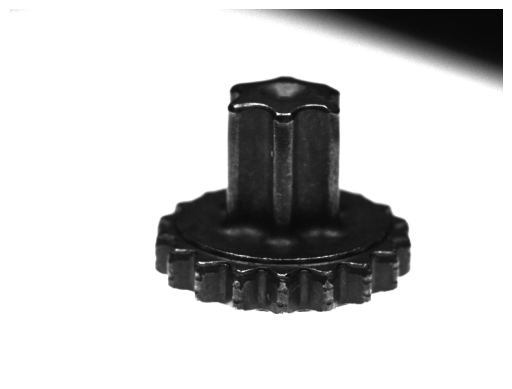

In [12]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image


image = Image.open(r"C:\Users\SimoneG\Documents\ultimi_datasets_tesi\ingranaggio_finale\classification\OK\Sample_C1_0000.bmp").convert("RGB")

# Carica immagine
inputs = processor(images=image, return_tensors="pt").to(model.device)

# Esegui inferenza
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

print(outputs.keys())
# Ottieni logits delle maschere predette
pred_masks = outputs.masks_queries_logits[0]  # [num_queries, H, W]
pred_logits = outputs.class_queries_logits[0]  # [num_queries, num_classes+1]

# Trova le predizioni più sicure (escludi background)
scores = pred_logits.softmax(-1)
labels = scores.argmax(-1)
keep = (labels != model.config.num_labels) & (scores.max(-1).values > 0.9)  # Adjusted threshold

filtered_masks = pred_masks[keep]
filtered_labels = labels[keep]

# Handle case where no masks are detected
if filtered_masks.shape[0] == 0:
    print("No masks detected with the current threshold.")
    # Display original image
    plt.imshow(image)
    plt.title("No masks detected")
    plt.axis('off')
    plt.show()
else:
    image_tensor_for_drawing = transforms.PILToTensor()(image)

    # Resize pred_masks to match image size
    original_size = image.size  # (W, H)
    target_height, target_width = original_size[1], original_size[0]

    # filtered_masks: [N, H_pred, W_pred] -> add batch dim to interpolate
    filtered_masks = F.interpolate(
        filtered_masks.unsqueeze(0),  # [1, N, H_pred, W_pred]
        size=(target_height, target_width),
        mode="bilinear",
        align_corners=False
    ).squeeze(0)  # Back to [N, H, W]


    # Le maschere devono essere binarie per il disegno
    masks_bin = filtered_masks > 0.5  # [N, H, W]
    masks_bin = masks_bin.cpu()

    # Disegna le maschere sull'immagine tensor
    overlay = draw_segmentation_masks(
        image_tensor_for_drawing, # Passa il tensore uint8
        masks=masks_bin,
        alpha=0.5,
        colors="red"
    )

    # Converti il tensore risultante in un'immagine PIL per visualizzazione
    overlay_pil = to_pil_image(overlay)

    # Transpose the tensor to have shape (H, W, C) before displaying
    plt.imshow(overlay.permute(1, 2, 0))
    plt.axis("off")
    plt.show()


## Classification report

In [13]:
def collate_fn2(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    pixel_mask = torch.stack([item["pixel_mask"] for item in batch])
    mask_labels = [item["mask_labels"] for item in batch]
    class_labels = [item["class_labels"] for item in batch]
    image_ids = [item["image_id"] for item in batch]

    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "mask_labels": mask_labels,
        "class_labels": class_labels,
        "image_id": image_ids,  # <-- aggiunto!
    }

In [30]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
from tqdm import tqdm

# Inizializza le liste
y_true_all = []
y_pred_all = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
images_dir = r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\dataset_split\test\images"
masks_dir = r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\dataset_split\test\masks"

test_loader = DataLoader(
    DefectSegmentationDataset(
        images_dir,
        masks_dir
    ),
    batch_size=1,  # per inferenza singola
    shuffle=False,
    collate_fn=collate_fn2,
    num_workers=0
)

for sample in tqdm(test_loader):  # oppure val_loader se è validazione
    
    pixel_values = sample["pixel_values"].to(device)
    pixel_mask = sample["pixel_mask"].to(device)
    image_id = sample["image_id"][0]  # es: "img1.png"
    # print(f"Pixel values shape {pixel_values.shape}")  # Dovrebbe essere [1, 3, H, W]
    # print(f"Pixel mask shape {pixel_mask.shape}")    # Dovrebbe essere [1, H, W]


    # Inferenza
    with torch.no_grad():
        # outputs = model(pixel_values.unsqueeze(0), pixel_mask=pixel_mask.unsqueeze(0))
        outputs = model(pixel_values, pixel_mask=pixel_mask)
    # print(type(outputs))

    # pred_masks = outputs.pred_masks  # [1, num_queries, H, W]
    pred_masks = outputs.masks_queries_logits[0]  # [num_queries, H, W]
    class_logits = outputs.class_queries_logits  # [1, num_queries, num_classes]
    
    # Trova maschere predette con label "defect"
    probs = class_logits.softmax(-1)
    class_scores, class_ids = probs.max(-1)  # [1, num_queries]
    defect_mask = (class_ids[0] == 0) & (class_scores[0] > 0.5)  # classe difetto
    
    # Combina tutte le maschere predette con soglia
    combined_pred = torch.zeros_like(pred_masks[0], dtype=torch.bool)

    for i in range(pred_masks.shape[0]):
        if defect_mask[i]:
            combined_pred = combined_pred | (pred_masks[i] > 0.5)

    pred_mask_bin = combined_pred.float()  # per confronto numerico dopo


    # Carica maschera reale
    #masks_dir = r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\scodellini_mask2former\dataset_split_scodellini\test\masks"
    mask_filename = f"{os.path.splitext(image_id)[0]}.png"
    mask_path = os.path.join(masks_dir, mask_filename)
    true_mask = Image.open(mask_path).convert("L")
    #true_mask = true_mask.resize(pred_mask_bin.shape[-2:], Image.NEAREST)
    true_mask = torch.from_numpy(np.array(true_mask)).float().to(device)
    # Resize maschera ground truth per matchare predizione
    true_mask = F.interpolate(true_mask.unsqueeze(0).unsqueeze(0), size=pred_mask_bin.shape[-2:], mode="nearest").squeeze()
    true_mask = (true_mask >= 1).float()
    

    # Flatten e aggiungi
    #y_true_all.extend(true_mask.view(-1).cpu().numpy())
    #y_pred_all.extend(pred_mask_bin.view(-1).cpu().numpy())

    y_true_all.extend(true_mask.cpu().numpy().flatten())
    y_pred_all.extend(pred_mask_bin.cpu().numpy().flatten())




from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true_all, y_pred_all))
print(confusion_matrix(y_true_all, y_pred_all))

100%|██████████| 146/146 [00:10<00:00, 14.34it/s]


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1344612
         1.0       0.69      0.72      0.70       924

    accuracy                           1.00   1345536
   macro avg       0.84      0.86      0.85   1345536
weighted avg       1.00      1.00      1.00   1345536

[[1344311     301]
 [    258     666]]


Classe 0.0 (__Background__):
* __Support__: 1,344,612 pixel → la stragrande maggioranza
* __Precision__: 1.00 → quasi nessun pixel classificato erroneamente come difetto
* __Recall__: 1.00 → tutti i pixel di background sono stati correttamente riconosciuti

Classe 1.0 (__Difetto__):
* __Support__: 924 pixel (pochissimi, quindi è class imbalance)
* __Precision__: 0.69 → tra tutti i pixel predetti come difetti, il 69% erano effettivamente difetti
* __Recall__: 0.72 → dei pixel realmente difettosi, il 72% sono stati correttamente trovati  

__F1-score__: 0.70 → armonica tra precision e recall

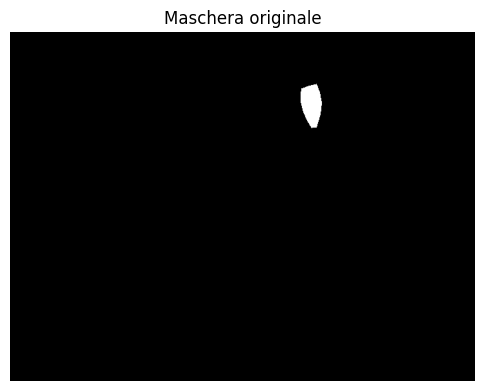

Pixel difetto (valori > 1): 1657


In [27]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Carica maschera
path = r"C:\Users\SimoneG\Desktop\notebooks_tesi\anomaly\ingranaggio_mask2former\dataset_split\test\masks\01ae49b7-Sample_C2_NOK_0050.png"
mask = Image.open(path).convert("L")  # scala di grigi
mask = np.array(mask)

# Visualizza in scala normale (0-255)
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap='gray')
plt.title("Maschera originale")
plt.axis("off")
plt.show()

# Conta pixel difetto
print("Pixel difetto (valori > 1):", np.sum(mask >= 1))


Le maschere sembrano tutte nere ma convertendole nuovamente in non binario si può vedere il difetto.